In [1]:
import torch
import torchani
from torchani.datasets import ANIDataset
from torchani.units import hartree2kcalpermol
from torchani.utils import PERIODIC_TABLE
import ase
from ase import io
from ase.optimize import BFGS
from ase.visualize import view

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pathlib import Path

In [2]:
def tensors_from_xyz(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        num_atoms = int(lines[0])
        coordinates = []
        species = []
        element, a, b, c = lines[2].split()
        cell = torch.diag(torch.tensor([float(a), float(b), float(c)]))
        for line in lines[2:]:
            values = line.split()
            if values:
                s = values[0].strip()
                x = float(values[1])
                y = float(values[2])
                z = float(values[3])
                coordinates.append([x, y, z])
                species.append(PERIODIC_TABLE.index(s))
        coordinates = torch.tensor(coordinates)
        species = torch.tensor(species, dtype=torch.long)
        assert coordinates.shape[0] == num_atoms
        assert species.shape[0] == num_atoms
    return species, coordinates



def covariances(atomic_energies):
    atomic_energies = atomic_energies.squeeze()
    cov = np.cov(atomic_energies,rowvar=False)
    atomic_variances = cov.diagonal()
    av_sum = atomic_variances.sum()
    atomic_stdev = np.sqrt(atomic_variances)
    estimated_qbc = np.sqrt(sum(sum(cov)))/np.sqrt(len(atomic_variances))
    
    just_covariances = estimated_qbc - np.sum(atomic_variances)
    
    qbc = atomic_energies.sum(1).std(0,ddof=1)/np.sqrt(len(atomic_variances)) # TorchANI uses unbiased stdev, so N-1
    
    
    assert math.isclose(qbc, estimated_qbc, abs_tol=0.0002) # Tolerance set to agree within 0.0002 Hartree (~.12 kcal/mol))

    print('(1) Atomic energy variance', '(2) Covariances', '(3) QBC')
    
    return av_sum, just_covariances, qbc

device = torch.device('cpu')
model = torchani.models.ANI2xr()
calculator = model.ase()

In [3]:
ds_path = Path('/Users/nickterrel/.local/share/torchani/Datasets/ANI-1x-first-conformers.h5')

ds = ANIDataset(locations=ds_path, names='1x first')
device = torch.device('cpu')
ani2xr = torchani.models.ANI2xr().double()
calculator = torchani.models.ANI2xr().ase()

In [4]:
ch4_species = ds['CH4']['species']
ch4_coord =   ds['CH4']['coordinates']

In [5]:
ase_ch4 = ase.Atoms(numbers=ch4_species[0],positions=ch4_coord[0])
ase_ch4.calc = calculator

dyn = BFGS(ase_ch4)
dyn.run(fmax=0.05)

ch4_coord = torch.tensor(ase_ch4.positions[None])
ch4 = (ch4_species, ch4_coord)

print(ch4)

      Step     Time          Energy          fmax
BFGS:    0 16:16:38    -1101.647705        5.533762
BFGS:    1 16:16:38    -1101.952026        1.600518
BFGS:    2 16:16:38    -1101.993042        0.878979
BFGS:    3 16:16:38    -1102.023438        0.518631
BFGS:    4 16:16:38    -1102.040527        0.449113
BFGS:    5 16:16:38    -1102.046021        0.162006
BFGS:    6 16:16:38    -1102.046997        0.069265
BFGS:    7 16:16:38    -1102.047119        0.035227
(tensor([[6, 1, 1, 1, 1]]), tensor([[[-4.0232e-04,  2.4051e-02,  4.7213e-02],
         [-9.1444e-01, -4.9060e-01, -2.5909e-01],
         [-2.1344e-01,  6.5118e-01,  9.1721e-01],
         [ 3.6255e-01,  6.4868e-01, -7.7390e-01],
         [ 7.6324e-01, -7.1503e-01,  3.0134e-01]]], dtype=torch.float64))


In [6]:
# Must use 'model.set_enabled("energy_shifter", False)' to get output w/o GSAEs
ani2xr.set_enabled("energy_shifter", False)
# Atomic energy, then sum over 
hartree2kcalpermol(ani2xr.atomic_energies(ch4,ensemble_values=True).energies.sum(1).std(0))

tensor([11.7615,  2.9427,  2.9396,  2.9388,  2.9430], dtype=torch.float64)

In [7]:
hartree2kcalpermol(ani2xr.atomic_energies(ch4,ensemble_values=True).energies.std(0))

tensor([[11.7615,  2.9427,  2.9396,  2.9388,  2.9430]], dtype=torch.float64)

In [8]:
hartree2kcalpermol(ani2xr.atomic_energies(ch4,ensemble_values=True).energies)

tensor([[[-219.4319,  -50.0001,  -50.0338,  -50.0290,  -50.0027]],

        [[-194.7116,  -56.1861,  -56.2130,  -56.2035,  -56.1903]],

        [[-192.8823,  -56.6347,  -56.6578,  -56.6536,  -56.6368]],

        [[-201.5672,  -54.4301,  -54.4605,  -54.4534,  -54.4336]],

        [[-196.5216,  -55.6916,  -55.7214,  -55.7133,  -55.6954]],

        [[-212.9309,  -51.5789,  -51.6102,  -51.6048,  -51.5817]],

        [[-186.5635,  -58.1870,  -58.2175,  -58.2056,  -58.1922]],

        [[-187.4423,  -57.9895,  -58.0100,  -58.0075,  -57.9908]]],
       dtype=torch.float64)

In [9]:
# Total energy per model
hartree2kcalpermol(ani2xr(ch4, ensemble_values=True).energies)

tensor([[-419.4976],
        [-419.5045],
        [-419.4653],
        [-419.3449],
        [-419.3433],
        [-419.3065],
        [-419.3658],
        [-419.4401]], dtype=torch.float64)

In [10]:
hartree2kcalpermol(ani2xr(ch4).energies)

tensor([-419.4085], dtype=torch.float64)

In [11]:
ch4_ae = hartree2kcalpermol(ani2xr.atomic_energies(ch4,ensemble_values=True).energies.squeeze().detach().numpy())
print(ch4_ae)

[[-219.43191773  -50.00009135  -50.03382141  -50.02904322  -50.00271756]
 [-194.71161625  -56.18610887  -56.21296353  -56.20352363  -56.19027869]
 [-192.88231548  -56.63473898  -56.65781144  -56.65355779  -56.6368453 ]
 [-201.56722612  -54.43014634  -54.46050759  -54.45343689  -54.43356306]
 [-196.52156401  -55.69160292  -55.72140463  -55.71330989  -55.69537748]
 [-212.93089617  -51.57885894  -51.61024281  -51.60481557  -51.58170645]
 [-186.56354095  -58.18695209  -58.2175399   -58.20561715  -58.19218979]
 [-187.44227916  -57.9894555   -58.00998517  -58.00754064  -57.99083344]]


In [12]:
ch4_ae.shape

(8, 5)

In [13]:
ch4_ae.sum(1).std(0,ddof=0)

0.07236723843674867

In [14]:
hartree2kcalpermol(ani2xr.energies_qbcs(ch4).qbcs.item()*math.sqrt(5))
# Equal up to float rounding precision

0.07736383207352418

In [15]:
print(covariances(ch4_ae))

(1) Atomic energy variance (2) Covariances (3) QBC
(172.93134613636636, -172.89674797886315, 0.03459815750325023)


In [16]:
hartree2kcalpermol(ani2xr(ch4, ensemble_values=True).energies.std(0).detach().numpy())

array([0.07736383])

[[138.33268849 -34.610257   -34.57382676 -34.56353341 -34.61300735]
 [-34.610257     8.6597402    8.65059345   8.6480356    8.66042048]
 [-34.57382676   8.65059345   8.64146677   8.63890287   8.65127661]
 [-34.56353341   8.6480356    8.63890287   8.63634844   8.64871503]
 [-34.61300735   8.66042048   8.65127661   8.64871503   8.66110224]]
Covariance matrix:
             0          1          2          3          4
0  138.332688 -34.610257 -34.573827 -34.563533 -34.613007
1  -34.610257   8.659740   8.650593   8.648036   8.660420
2  -34.573827   8.650593   8.641467   8.638903   8.651277
3  -34.563533   8.648036   8.638903   8.636348   8.648715
4  -34.613007   8.660420   8.651277   8.648715   8.661102

AE variance (stdev squared):
 [138.33268849   8.6597402    8.64146677   8.63634844   8.66110224]
Sum of AE stdev:
 23.525614146691357

Sum of covariances (off-diagonal elements):
 -23.448250314617948
QBC from ANI (w/o dividing by N_atoms):
 [0.07736383] (kcal/mol)
Sqrt of the sum over enti

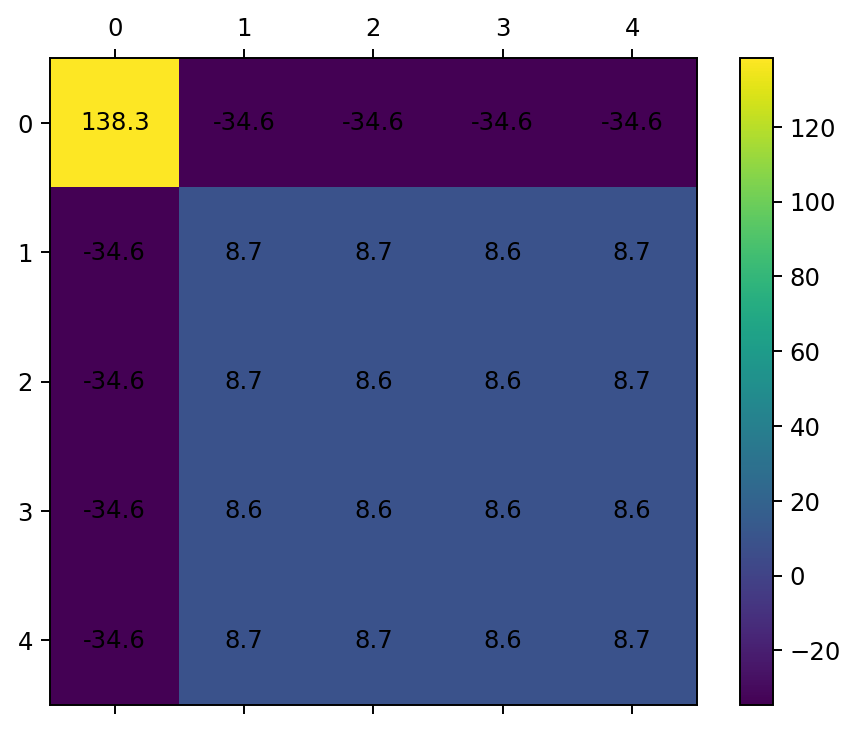

In [49]:
ch4_cov = np.cov(ch4_ae,rowvar=False)
print(ch4_cov)
print('Covariance matrix:\n',pd.DataFrame(ch4_cov))
atomic_variances = ch4_cov.diagonal()
atomic_stdev = np.sqrt(atomic_variances)
print()
print('AE variance (stdev squared):\n',atomic_variances)
print('Sum of AE stdev:\n',np.sum(atomic_stdev))
print()

sqrt_sum_cov = np.sqrt(sum(sum(ch4_cov)))
ch4_qbc = hartree2kcalpermol(ani2xr(ch4, ensemble_values=True).energies.std(0).detach().numpy())
only_covariances = sqrt_sum_cov - np.sum(atomic_stdev)

print('Sum of covariances (off-diagonal elements):\n',only_covariances)

print('QBC from ANI (w/o dividing by N_atoms):\n',ch4_qbc,'(kcal/mol)')
print('Sqrt of the sum over entire covariance matrix:\n',sqrt_sum_cov,'(kcal/mol)')

plt.rcParams['figure.dpi'] = 175

fig, ax = plt.subplots()
img = ax.matshow(ch4_cov)#, cmap='seismic_r')
fig.colorbar(img)

for (i, j), z in np.ndenumerate(ch4_cov):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontweight=500)

plt.savefig('./ch4_covariance.png')

In [22]:
ch4_cov

array([[138.33268849, -34.610257  , -34.57382676, -34.56353341,
        -34.61300735],
       [-34.610257  ,   8.6597402 ,   8.65059345,   8.6480356 ,
          8.66042048],
       [-34.57382676,   8.65059345,   8.64146677,   8.63890287,
          8.65127661],
       [-34.56353341,   8.6480356 ,   8.63890287,   8.63634844,
          8.64871503],
       [-34.61300735,   8.66042048,   8.65127661,   8.64871503,
          8.66110224]])

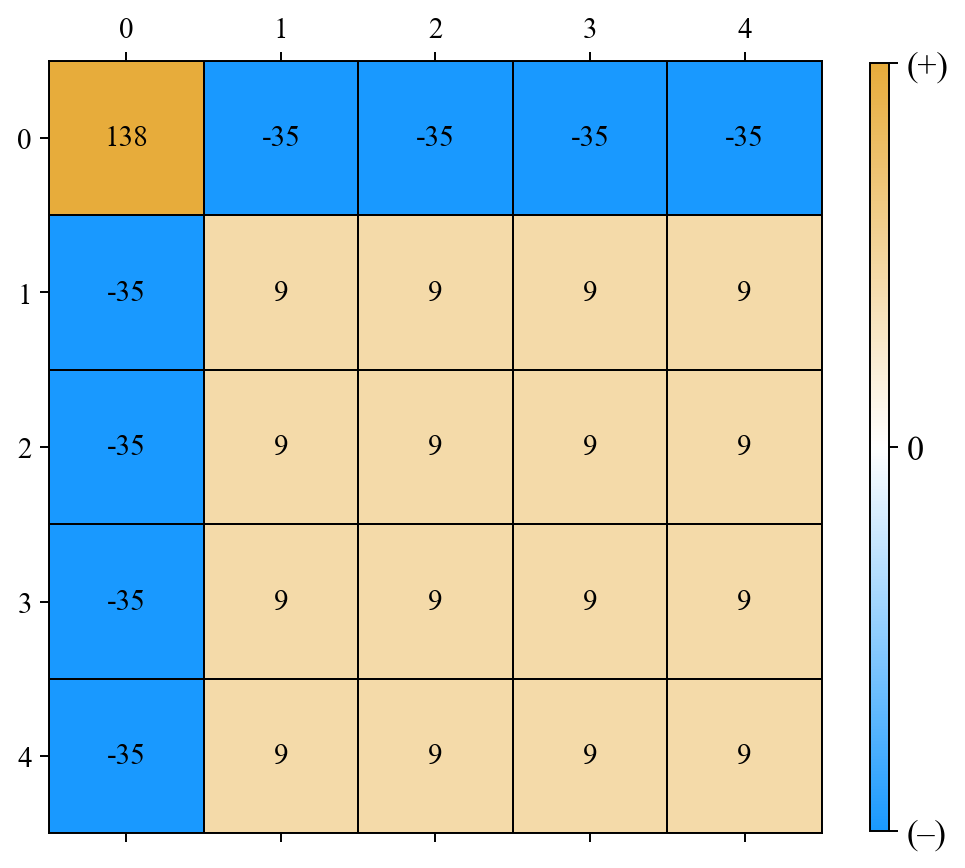

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches  # Import patches for outlining

plt.rcParams['font.family'] = 'Times New Roman'

# Your covariance matrix
ch4_cov = np.cov(ch4_ae, rowvar=False)

# Define custom colormap with the new orange shade
clist = [
    (0.1, 0.6, 1.0),  # Blue for negative values
    (1.0, 1.0, 1.0),  # White at zero
    (231/255, 172/255, 59/255)  # New bright orange for positive values
]
cmap = LinearSegmentedColormap.from_list("cmap_name", clist)

# Normalize values with zero at the center
norm = mcolors.TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)

# Create figure
plt.rcParams['figure.dpi'] = 175
fig, ax = plt.subplots(figsize=(6, 6))  # Match figure size

# Plot the covariance matrix with the updated colormap
img = ax.matshow(ch4_cov, cmap=cmap, norm=norm)
cbar = fig.colorbar(img, shrink=0.77, aspect=40)  # Match colorbar size

# Customize color bar
#cbar.set_label('Covariance Values', fontsize=10)
cbar.set_ticks([-20, 0, 20])  # Set colorbar ticks at key points
cbar.ax.set_yticklabels(['(–)', '0', '(+)'], fontsize=14, fontweight=500)  # Match styling

# Annotate each cell with integer values and outline with black border
for (i, j), z in np.ndenumerate(ch4_cov):
    ax.text(j, i, '{:d}'.format(int(round(z))), ha='center', va='center', fontweight=500, fontsize=12)  # Round values
    rect = patches.Rectangle((j - 0.5, i - 0.5), 1, 1, linewidth=0.8, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

# Adjust tick labels on the axes
ax.set_xticks(range(ch4_cov.shape[1]))
ax.set_yticks(range(ch4_cov.shape[0]))
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap

# Save figure
plt.savefig('./ch4_covariance_golden_orange.png')

plt.show()

In [41]:
hartree2kcalpermol(covariances(ch4_ae)[2]/math.sqrt(5))

(1) Atomic energy variance (2) Covariances (3) QBC


9.709307512508616

In [48]:
print('Mol_E stdev:',ani2xr.energies_qbcs(ch4).qbcs.item()*math.isqrt(5))
print('Atom_E stdev:',torch.tensor(ch4_ae).std(0, unbiased=True))
print('Sum of AE_std:',torch.tensor(ch4_ae).std(0, unbiased=True).sum(0))
print()
print('Covariance matrix:\n',ch4_cov)
print('Diagonal of cov matrix:\n',ch4_cov.diagonal()) # This gives "variances"


Mol_E stdev: 0.00011027134710421398
Atom_E stdev: tensor([11.7615,  2.9427,  2.9396,  2.9388,  2.9430], dtype=torch.float64)
Sum of AE_std: tensor(23.5256, dtype=torch.float64)

Covariance matrix:
 [[138.33268849 -34.610257   -34.57382676 -34.56353341 -34.61300735]
 [-34.610257     8.6597402    8.65059345   8.6480356    8.66042048]
 [-34.57382676   8.65059345   8.64146677   8.63890287   8.65127661]
 [-34.56353341   8.6480356    8.63890287   8.63634844   8.64871503]
 [-34.61300735   8.66042048   8.65127661   8.64871503   8.66110224]]
Diagonal of cov matrix:
 [138.33268849   8.6597402    8.64146677   8.63634844   8.66110224]


In [38]:
ch4_ae

array([[-219.43191773,  -50.00009135,  -50.03382141,  -50.02904322,
         -50.00271756],
       [-194.71161625,  -56.18610887,  -56.21296353,  -56.20352363,
         -56.19027869],
       [-192.88231548,  -56.63473898,  -56.65781144,  -56.65355779,
         -56.6368453 ],
       [-201.56722612,  -54.43014634,  -54.46050759,  -54.45343689,
         -54.43356306],
       [-196.52156401,  -55.69160292,  -55.72140463,  -55.71330989,
         -55.69537748],
       [-212.93089617,  -51.57885894,  -51.61024281,  -51.60481557,
         -51.58170645],
       [-186.56354095,  -58.18695209,  -58.2175399 ,  -58.20561715,
         -58.19218979],
       [-187.44227916,  -57.9894555 ,  -58.00998517,  -58.00754064,
         -57.99083344]])

In [49]:
covariances(ch4_ae)

(1) Atomic energy variance (2) Covariances (3) QBC


(172.93134613636664, -172.89674797886335, 0.03459815750324223)